## Tensorflow Implementation

In [1]:
import sys
from scipy.special import logsumexp
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from autograd.scipy.stats import multivariate_normal
import numpy
import math
import pdb
import time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

In [2]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy as sp

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from IPython.display import clear_output
# Plotting libraries
import matplotlib.pyplot as plt

In [3]:
# tf.config.experimental.list_physical_devices('GPU')

In [4]:
plt.rcParams.update({'font.size': 22})

### Implementation of Aggressive Training

In [5]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        # your code here
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) #stdev = 1.
        epsilon.set_shape(z_mean.shape)
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon
        # end your code here
        return z

In [6]:
def make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim=1, n_channels = 1):
    # input
    input = layers.Input(shape=input_dim)

    encoder_seq = models.Sequential()
    if n_channels>1: encoder_seq.add(layers.Flatten())
    for i in range(len(enc_intermediate_dim)):
      encoder_seq.add(layers.Dense(enc_intermediate_dim[i], activation='relu', name=f'encoder{i}'))
    x_encoded = encoder_seq(input)

    z_mean = layers.Dense(bottleneck_dim, activation='linear', name='z_mean')(x_encoded)
    z_log_var = layers.Dense(bottleneck_dim, activation='linear', name='z_log_var')(x_encoded) 
    encoder = models.Model(inputs=input, outputs=[z_mean, z_log_var], name='encoder')

    return encoder
    
def make_decoder(input_dim, dec_intermediate_dim, n_channels = 1):
    
    if n_channels>1:
      flat_dim = np.product(input_dim)

    decoder_seq = models.Sequential(name='decoder')

    for i in range(len(dec_intermediate_dim)):
      decoder_seq.add(layers.Dense(dec_intermediate_dim[i], activation='relu', name=f'decoder{i}'))

    if n_channels>1:
      decoder_seq.add(layers.Dense(flat_dim, activation='sigmoid'))
      decoder_seq.add(layers.Reshape(input_dim))
    else:
      decoder_seq.add(layers.Dense(input_dim))

    return decoder_seq


In [7]:
def sample_latent_variable(latent_mean, latent_logstd):
    return np.random.randn(*latent_mean.shape) * np.exp(latent_logstd) + latent_mean
    
def diag_gaussian_log_density(x, mu, latent_logstd):
    return np.sum(sp.stats.norm.logpdf(x, mu, np.exp(latent_logstd)), axis=-1)

def make_latent_plot1D(X_data, encoder, decoder, ax, n=100, min_z=-10, max_z=10, stride=0.01):
    X_samples = X_data[np.random.choice(len(X_data), size=n, replace=False)]

    z_points = np.linspace(min_z, max_z, int((2 * max_z / stride) ))

    approx_mu, _ = encoder(X_samples)
    approx_mu = approx_mu.numpy()

    true_mu = []

    for i in range(n):
    # if i % 10 == 0:
    #     print(i)
    X = X_samples[i, :]

    posterior_probs =[]
    # log_prior = diag_gaussian_log_density(z_points, 0, 0)
    log_prior = sp.stats.norm.logpdf(z_points, 0., 1.)
    output_mean = decoder(z_points).numpy()
    log_likelihood = diag_gaussian_log_density(X, output_mean, 0. )
    posterior_probs = np.exp(log_prior + log_likelihood)

    posterior_probs = np.array(posterior_probs) / np.sum(posterior_probs)   
    true_mu.append(np.sum(z_points * posterior_probs))

    max_val = 3
    # fig, ax = plt.subplots(1,1,figsize=(10, 6))
    ax.set_xlim((-max_val, max_val))
    ax.set_ylim((-max_val, max_val))
    ax.scatter(true_mu, approx_mu, color='r', marker='x')
    ax.axvline(x=0, color='k', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
    ax.plot([-max_val, max_val], [-max_val, max_val], color='purple', linestyle='--', linewidth=2)
    ax.set_xlabel('true mu')
    ax.set_ylabel('approximate mu')

    return true_mu, approx_mu, fig, ax

In [24]:
def basic_training(encoder, decoder, enc_optimizer, dec_optimizer, train_dataset, vae_loss, axes, epochs=20, n_plots=4, make_latent_plot1D=make_latent_plot1D, show_plot=True):
    freq_plot = int(epochs/n_plots)

    for epoch in range(epochs):
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, _) in enumerate(train_dataset):

            # Train the encoder & decoder at the same time
            with tf.GradientTape() as tape:
                z_mean, z_log_var = encoder(x_batch_train)
                z_samples = Sampling()([z_mean, z_log_var])
                x_decoded = decoder(z_samples)

                loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg)

            grads = tape.gradient(loss, encoder.trainable_weights + decoder.trainable_weights)
            enc_optimizer.apply_gradients(zip(grads, encoder.trainable_weights + decoder.trainable_weights))

        # make the plot at first epoch
        if show_plot and epoch==0:
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[0], min_z = -10, max_z=10)
        
        # make the plot with the given frequency
        if show_plot and ((epoch+1) % freq_plot == 0):
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[int((epoch+1)/freq_plot)], min_z = -10, max_z=10)


    if show_plot:
        return encoder, decoder, fig, ax
    else:
        return encoder, decoder


In [28]:
def aggressive_training(encoder, decoder, enc_optimizer, dec_optimizer, train_dataset, vae_loss, axes,epochs=20, n_plots=4, make_latent_plot1D=make_latent_plot1D, show_plot=True):

    freq_plot = int(epochs/n_plots) 

    for epoch in range(epochs):

        # ---------------------------------------------------------------------------
        # Train the encoder 
        # Iterate over the batches of the dataset (ENTIRE dataset)
        for step, (x_batch_train, _) in enumerate(train_dataset):

            encoder.trainable=True
            decoder.trainable=False

            with tf.GradientTape() as tape:
                z_mean, z_log_var = encoder(x_batch_train)
                z_samples = Sampling()([z_mean, z_log_var])
                x_decoded = decoder(z_samples)

                enc_loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg)

            grads = tape.gradient(enc_loss, encoder.trainable_weights)
            enc_optimizer.apply_gradients(zip(grads, encoder.trainable_weights))

        # ---------------------------------------------------------------------------
        # Train the decoder
        # Iterate over the 1 batch of the dataset only
        for step, (x_batch_train, _) in enumerate(train_dataset.take(1)):

            encoder.trainable=False
            decoder.trainable=True

            with tf.GradientTape() as tape:
                z_mean, z_log_var = encoder(x_batch_train)
                z_samples = Sampling()([z_mean, z_log_var])
                x_decoded = decoder(z_samples)

                dec_loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg)

            grads = tape.gradient(dec_loss, decoder.trainable_weights)
            dec_optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
        
        # make the plot at first epoch
        if show_plot and epoch==0:
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[0], min_z = -10, max_z=10)
        
        # make the plot with the given frequency
        if show_plot and ((epoch+1) % freq_plot == 0):
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[int((epoch+1)/freq_plot)], min_z = -10, max_z=10)

    if show_plot:
        return encoder, decoder, fig, ax
    else:
        return encoder, decoder

In [10]:
np.random.seed(207)
mean = np.array([1, 2, 3])
cov = np.eye(len(mean))
X_data = np.random.multivariate_normal(mean=mean, cov=cov, size=1000)
X_validation = np.random.multivariate_normal(mean=mean, cov=cov, size=100)


In [11]:
batch_size = 256
buffer_size=1000
reg = 1.

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((X_data, X_data))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_validation, X_validation))
val_dataset = val_dataset.batch(batch_size)

# Define loss
mse = losses.MeanSquaredError()
def vae_loss(x, x_decoded_mean, z_mean, z_log_var, reg):
    xent_loss = mse(x, x_decoded_mean)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    loss = xent_loss + reg*kl_loss
    return loss


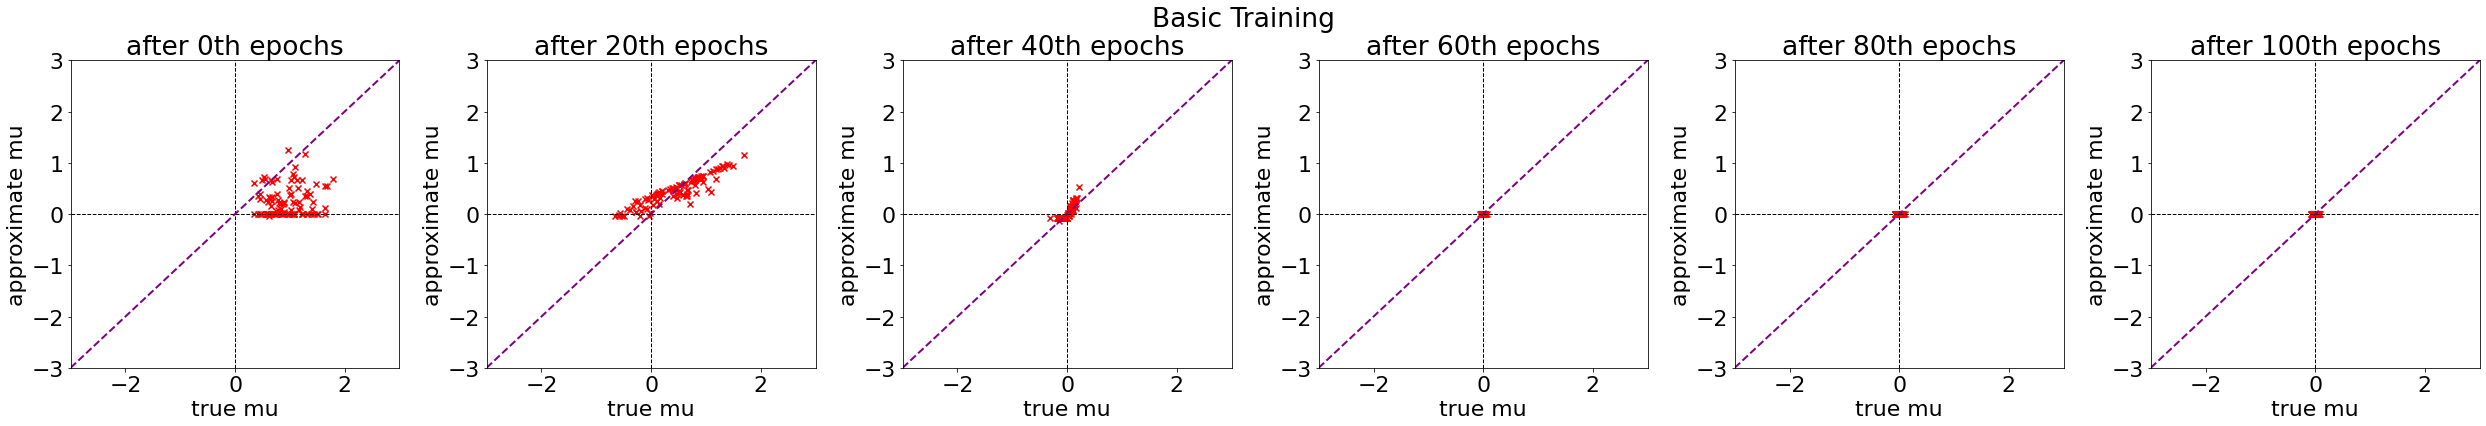

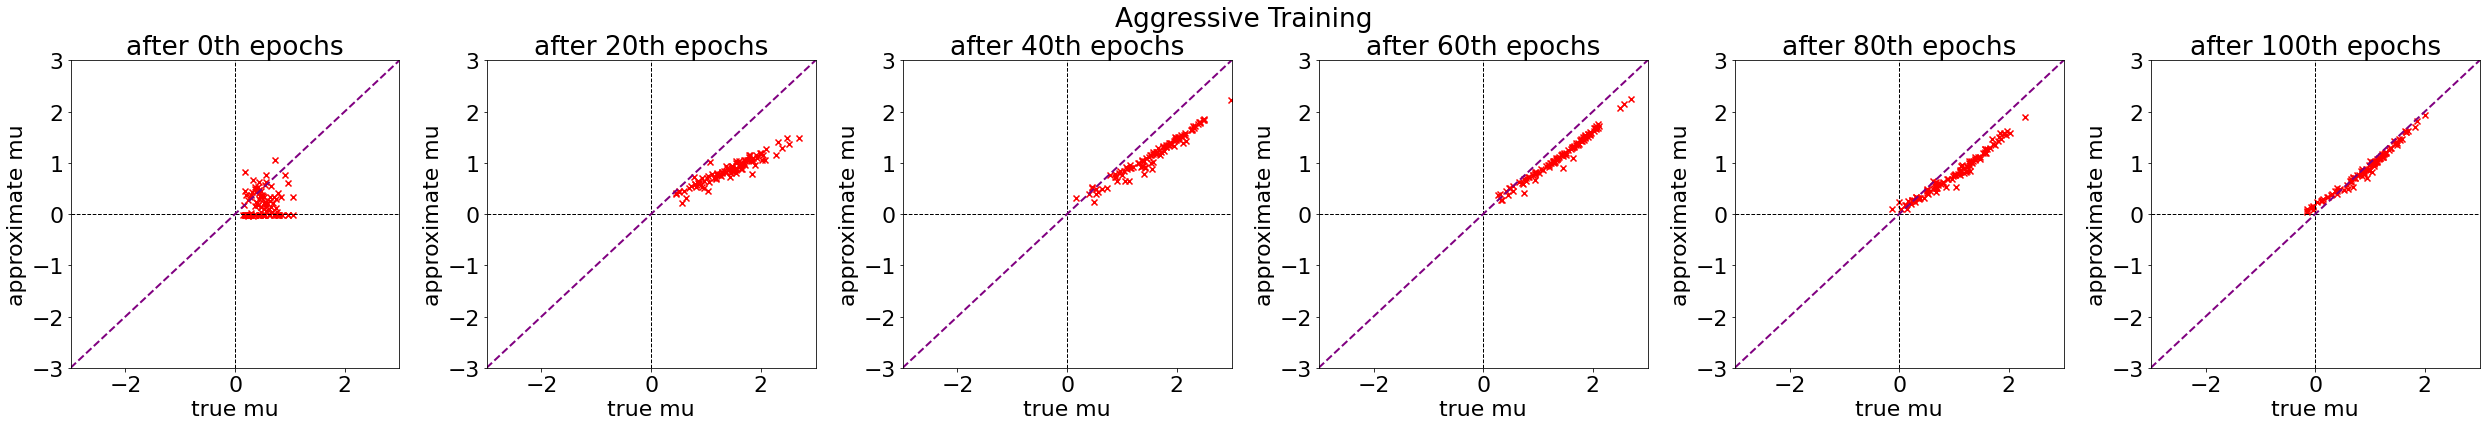

In [29]:
epochs=100
n_plots=5

# Instantiate one optimizer for the discriminator and another for the generator.
enc_optimizer = optimizers.RMSprop(learning_rate=0.002)
dec_optimizer = optimizers.RMSprop(learning_rate=0.001)

# build encoder and decoder
input_dim = len(mean)
enc_intermediate_dim=[16,8,2]
dec_intermediate_dim=[2,12,16]
bottleneck_dim=1

# Basic Training
K.clear_session()
tf.random.set_seed(207)
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)

fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Basic Training", y=1.01)
for i in range(n_plots+1):
    axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")
    
encoder, decoder, fig, axes = basic_training(encoder, decoder, enc_optimizer = enc_optimizer, dec_optimizer =dec_optimizer, 
                                             train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()

# Agressive Training
K.clear_session()
tf.random.set_seed(207)
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)

fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Aggressive Training", y=1.01)
for i in range(n_plots+1):
    axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

encoder, decoder, fig, axes = aggressive_training(encoder, decoder, enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                  train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()

#### Check for correctness for the aggressive training implementation

Starting with decent decoder and new UNTRAINED encoder
If the codes for basic & aggressive training works accordingly, then
- basic training => everything falls apart because the encoder won't be able to catch up
- aggressive training => encoder will catch up quickly to produce decent pair of encoder & decoder

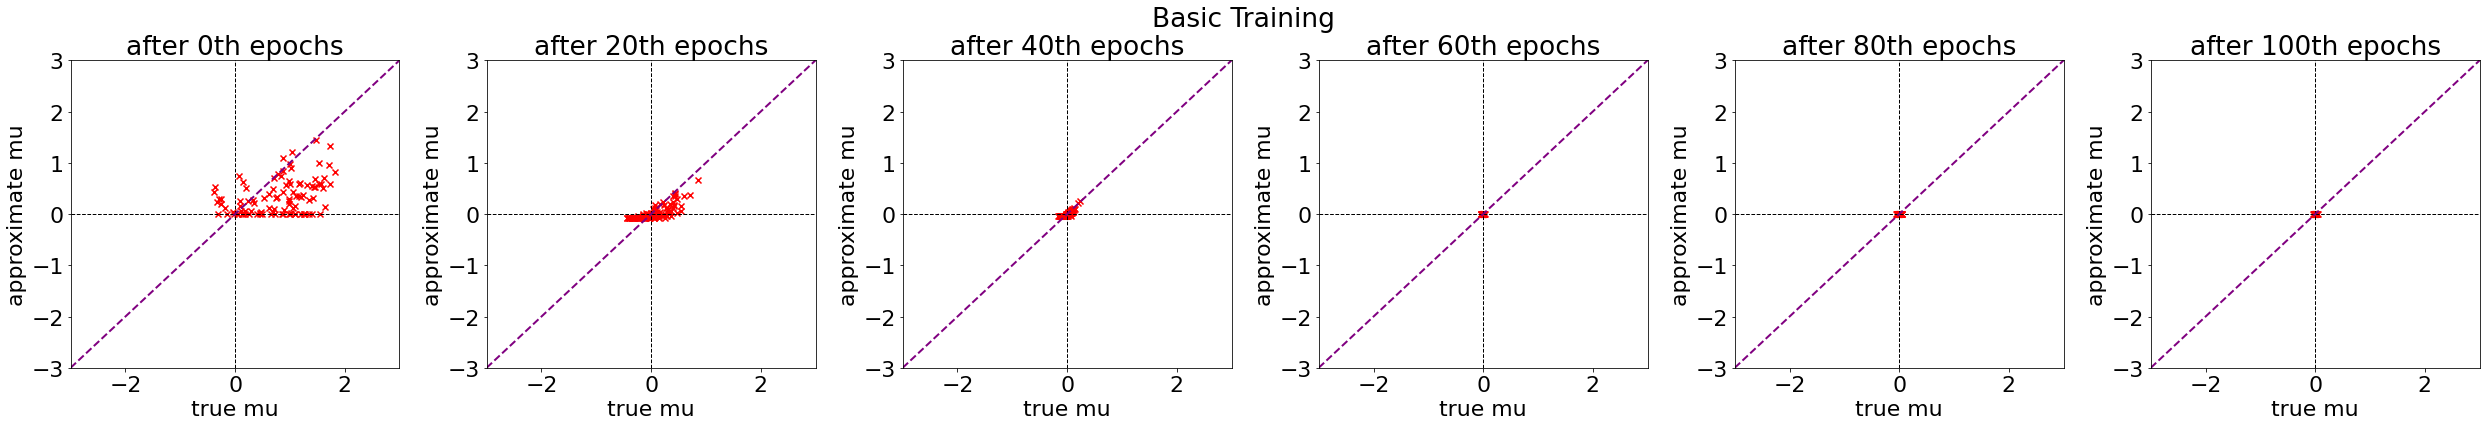

In [30]:
# trained the VAE till we get a decent encoder & decoder
K.clear_session()
tf.random.set_seed(207)
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)
encoder, decoder = aggressive_training(encoder, decoder, enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                       train_dataset=train_dataset, vae_loss=vae_loss, 
                                       axes=axes, epochs=epochs, n_plots=n_plots, show_plot=False)

# use trained decoder, and a new untrained encoder
input_dim = len(mean)
enc_intermediate_dim=[16,8,2]
dec_intermediate_dim=[2,12,16]
bottleneck_dim=1
encoder_new = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)  
# Basic Training
fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Basic Training", y=1.01)
for i in range(n_plots+1):
  axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")
encoder2, decoder2,fig,axes = basic_training(encoder_new, decoder, enc_optimizer = enc_optimizer, dec_optimizer =dec_optimizer, 
                                             train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()


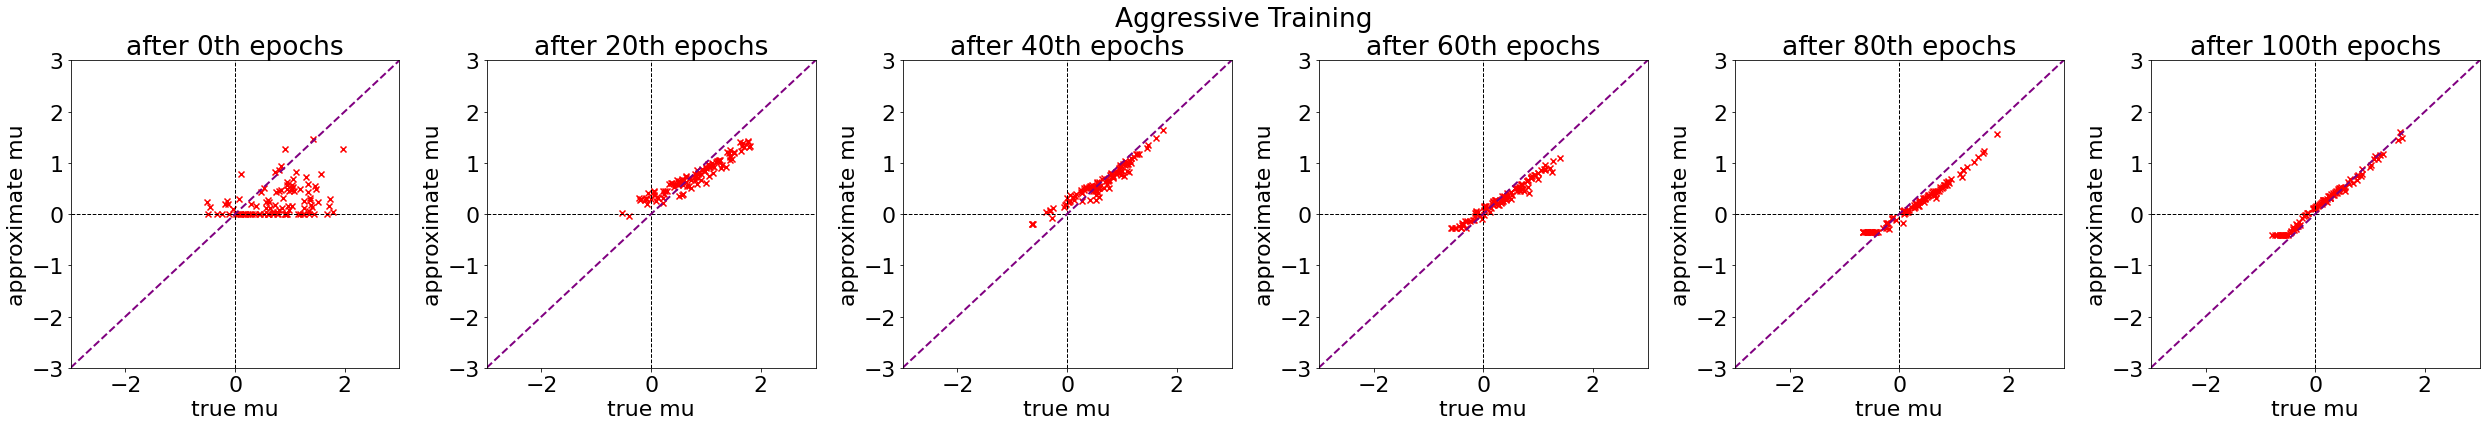

In [31]:
# trained the VAE till we get a decent encoder & decoder
K.clear_session()
tf.random.set_seed(207)
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)
encoder, decoder = aggressive_training(encoder, decoder, enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                       train_dataset=train_dataset, vae_loss=vae_loss, 
                                       axes=axes, epochs=epochs, n_plots=n_plots, show_plot=False)

# Agressive Training
fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Aggressive Training", y=1.01)
for i in range(n_plots+1):
    axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

encoder_new = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)  

encoder2,decoder2,fig, axes = aggressive_training(encoder_new, decoder, enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                  train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()


Passed the tests: aggressive training is able to force the new encoder to learn & catch up with the trained decoder while the basic training can't.

#### Check for correcness for the VAE

Decoder should be able to generate synthetic data with similar distribution to the training data (starting with random normal samples).


In [57]:
# generate synthetic data for random normal
z_synthetic = np.random.normal(0., 1., size=1000)
np.mean(decoder2.predict(z_synthetic), axis=0)

array([0.9518701, 1.7658094, 2.7232842], dtype=float32)

Passed the test: Mean of the synthetically generated data is pretty close to the true mean (training data is multivariate gaussian distribution with mean [0,1,2])